In [66]:
%load_ext autoreload 
%autoreload 2

import scipy
import pandas as pd
#from age_balance_analysis import channels, biomass, labelling
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from age_balance_analysis import util
from tqdm.notebook import tqdm

sns.set_style("whitegrid")

DATA_PATH = Path("../data/lysine_vacule_knockouts")
LABELLING_DATA_PATH = DATA_PATH / "2024-02-19_MS_proteins_EO_3.tsv"
FRACTIONATED_DATA_PATH = DATA_PATH / "2024-02-25_MS_proteins_EO_6.tsv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t").rename(
    columns={"PG.ProteinGroups": "gene"}
)
unfractionated_df["time_h"] = unfractionated_df.time_min / 60.0

condition strain           pulse_type  \
experiment                                                         
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_time_points  growth_rate  
experiment                                              
9                     30                3     0.357593  
10                    30                3     0.354332  
11                    37                3     0.340428  
12                    37                3     0.345937

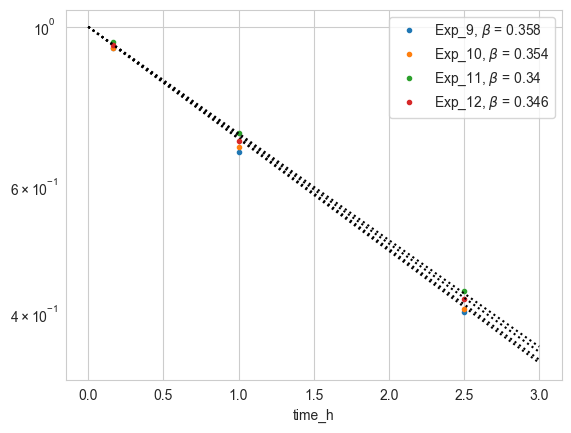

In [5]:
metadata_df = unfractionated_df[
    ["experiment", "condition", "strain", "pulse_type", "temp_celsius", "time_h"]
].drop_duplicates()
metadata_df = metadata_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().time_h.reset_index().set_index("experiment")
metadata_df.rename(columns={"time_h": "num_time_points"}, inplace=True)
metadata_df = metadata_df[metadata_df.num_time_points > 1]

# Use the Biomass data to calculate the growth rates
fig, ax = plt.subplots(1, 1)
growth_rates = {}
for idx, group_df in unfractionated_df.groupby(["experiment"]):
    biomass_df = group_df.groupby(["time_h", "replicate"]).growth_dilution.mean().reset_index()
    if biomass_df.shape[0] > 1:
        linreg_result = scipy.stats.linregress(biomass_df.time_h, np.log(biomass_df.growth_dilution))
        growth_rates[idx] = -linreg_result.slope
        biomass_df.plot(x="time_h", y="growth_dilution", style=".", label=f"Exp_{idx[0]}, $\\beta$ = {growth_rates[idx]:.3g}", ax=ax)
        ax.plot([0, 3], [1, np.exp(-growth_rates[idx]*3)], 'k:')
        
ax.set_yscale("log")
metadata_df = metadata_df.join(pd.Series(growth_rates, name="growth_rate"), on="experiment")
metadata_df

In [7]:
result_list = []

filtered_df = unfractionated_df[(unfractionated_df.channel == "K1") & (unfractionated_df.precursor_no > 20)]

for experiment, row in metadata_df.iterrows():
    # use the Exp. and protein as the index (the 2 repeats will be pooled together)
    _df = filtered_df[filtered_df.experiment == experiment].pivot(index="gene", columns="time_h", values="labelling").dropna()
    for idx in tqdm(_df.index, desc=f"Exp_{experiment}"):
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[idx, :].to_numpy()
        tau_lbs = np.array([5e-3, 1./row.growth_rate-1e-5])
        tau_ubs = np.array([10,  1./row.growth_rate+1e-5])
        popt, pcov, mse = util.fit_taus(xdata, ydata, measured_pool_index=1, tau_lbs=tau_lbs, tau_ubs=tau_ubs)
        lysine_pool_mean = popt[0]
        lysine_pool_std = np.sqrt(pcov[0, 0])
        result_list.append((experiment, idx, lysine_pool_mean, lysine_pool_std, mse))

Exp_9:   0%|          | 0/103 [00:00<?, ?it/s]

Exp_10:   0%|          | 0/98 [00:00<?, ?it/s]

Exp_11:   0%|          | 0/78 [00:00<?, ?it/s]

Exp_12:   0%|          | 0/77 [00:00<?, ?it/s]

In [8]:
result_df = pd.DataFrame(result_list, columns=["experiment", "gene", "lysine_pool_mean", "lysine_pool_std", "mse"])

(-0.2, 2.0)

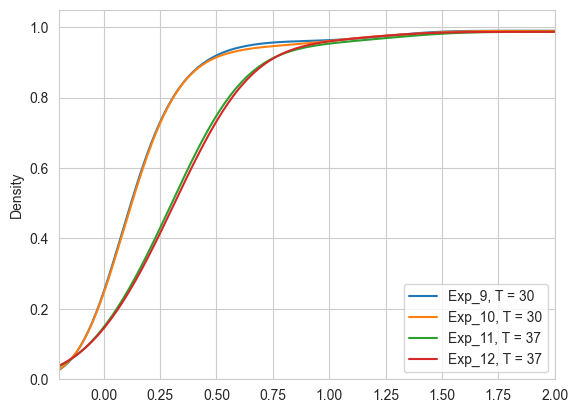

In [18]:
fig, ax = plt.subplots(1, 1, dpi=100)
for experiment, row in metadata_df.iterrows():
    pool_data = result_df[result_df.experiment == experiment].lysine_pool_mean.values
    sns.kdeplot(pool_data, ax=ax, cumulative=True, label=f"Exp_{experiment}, T = {row.temp_celsius}")
ax.legend()
ax.set_xlim(-0.2, 2)

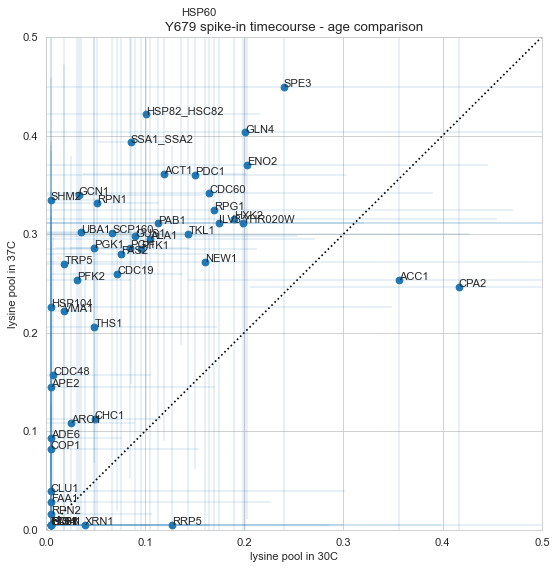

In [65]:
_df = result_df[result_df.lysine_pool_std < 0.5].join(
        metadata_df, on="experiment"
    ).groupby(
        ["gene", "temp_celsius"]
    )[["lysine_pool_mean", "lysine_pool_std"]].mean(
    ).reset_index().dropna()

age_df = _df.pivot(index="gene", columns="temp_celsius", values=["lysine_pool_mean", "lysine_pool_std"]).dropna()

xdata = age_df[('lysine_pool_mean', 30)]
ydata = age_df[('lysine_pool_mean', 37)]
xerr = age_df[('lysine_pool_std', 30)]
yerr = age_df[('lysine_pool_std', 37)]

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=80)
ax.errorbar(x=xdata, y=ydata, xerr=xerr, yerr=yerr, fmt="o", elinewidth=0.2)
ax.plot([0, 1], [0, 1], 'k:')
for idx in (np.abs(xdata - ydata) > 0.1).index:
    ax.text(xdata[idx], ydata[idx], idx)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
ax.set_title("Y679 spike-in timecourse - age comparison")
ax.set_xlabel("lysine pool in 30C")
ax.set_ylabel("lysine pool in 37C");

In [60]:
result_df

experiment     gene  lysine_pool_mean  lysine_pool_std       mse
0             9     AAT2          0.312370         0.391708  0.000909
1             9     ACC1          0.387246         0.189252  0.000149
2             9     ACO1          0.320539         0.237444  0.000322
3             9     ACO2          1.252482         5.179181  0.001102
4             9     ACS2          0.184941         0.243039  0.000534
..          ...      ...               ...              ...       ...
351          12     VAS1          0.355022         0.592689  0.001640
352          12     VMA1          0.223939         0.255047  0.000504
353          12     YEF3          0.431280         0.814737  0.002106
354          12  YHR020W          0.317730         0.501566  0.001390
355          12  YNL247W          0.506473         1.127039  0.002670

[356 rows x 5 columns]

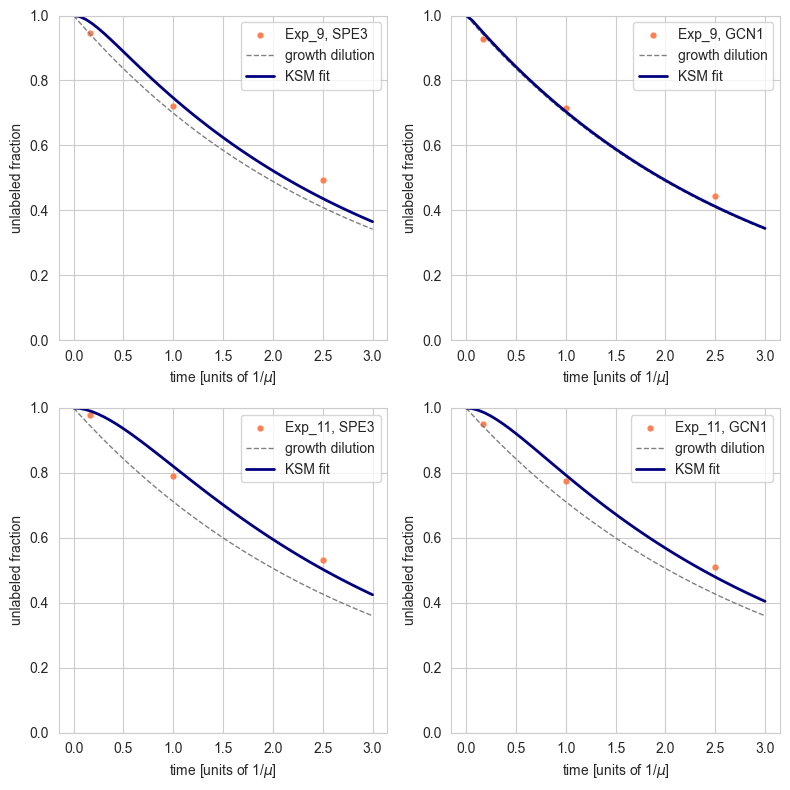

In [64]:
exp_1 = 9
exp_2 = 11
gene_1 = "SPE3"
gene_2 = "GCN1"

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=100)

lys_pool = result_df.set_index(["experiment", "gene"]).lysine_pool_mean

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[gene, :].to_numpy()

        t_range = np.linspace(start=0, stop=3, num=50)
    
        ydata_growth = np.array([np.exp(-growth_rate * t) for t in t_range])
        ydata_pred = util.f_labelling(t_range, 1, *[lys_pool[exp, gene], 1./growth_rate])
    
        ax.scatter(xdata, ydata, color="coral", s=12, label=f"Exp_{exp}, {gene}")
        ax.plot(t_range, ydata_growth, '--', color="grey", linewidth=1,
                label="growth dilution")
        ax.plot(t_range, ydata_pred, '-', color="navy", linewidth=2, label="KSM fit")
        ax.set_ylim(0, 1)
        ax.set_ylabel("unlabeled fraction")
        ax.set_xlabel("time [units of 1/$\\mu$]")
        ax.legend()
fig.tight_layout()